# Read data and data processing

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
import pandas as pd
import japanize_matplotlib

tochi_train = pd.read_csv('../data/train_genba.tsv', sep='\t')
build_train = pd.read_csv('../data/train_goto.tsv', sep='\t')
train = pd.merge(tochi_train, build_train, on="pj_no")

tochi_test = pd.read_csv('../data/test_genba.tsv', sep='\t')
build_test = pd.read_csv('../data/test_goto.tsv', sep='\t')
test = pd.merge(tochi_test, build_test, on="pj_no")

print ("Train: 販売数は",train.shape[0],"件、特徴量は",train.shape[1],"個。")
print ("Test: 販売数は",test.shape[0],"件、特徴量は",test.shape[1],"個。")

first_submission = pd.DataFrame()
first_submission['id'] = test['id']

Train: 販売数は 6461 件、特徴量は 158 個。
Test: 販売数は 4273 件、特徴量は 157 個。


In [4]:
# 名前系と相関性が高いカラムはとりあえず削除
# 土地のネームバリューが出てくると思うので、名前系はあとで追加するかも

name_columns = ['bastei_nm1','bastei_nm2','chiseki_kb_hb','eki_nm1','eki_nm2','gk_chu_tm','gk_sho_tm','hy1f_date_su', \
                'hy2f_date_su','mseki_yt_hb','tc_mseki','yoseki2','id']
train.drop(name_columns, axis=1, inplace=True)
test.drop(name_columns, axis=1, inplace=True)

y_train = train['keiyaku_pr']

In [5]:
# カテゴリ系コラムにある「無」に値を振り分けたり、変換ミスに対処したり、マルバツからBooleanに変換

import numpy as np

train['fi3m_yohi'].replace('（無）','（不要）',inplace=True)
train['hiatari'].fillna('普通', inplace=True)
train['kborjs'].replace('公募','公簿',inplace=True)
test['fi3m_yohi'].replace('（無）','（不要）',inplace=True)
test['hiatari'].fillna('普通', inplace=True)
test['kborjs'].replace('公募','公簿',inplace=True)

maru_columns = ['rs_e_kdate2','rs_e_kdate3','rs_e_m_ari','rs_e_m_nashi','rs_e_parking','rs_e_tahata','rs_e_zoki', \
                'rs_n_kdate2','rs_n_kdate3','rs_n_m_ari','rs_n_m_nashi','rs_n_parking','rs_n_tahata','rs_n_zoki', \
                'rs_s_kdate2','rs_s_kdate3','rs_s_m_ari','rs_s_m_nashi','rs_s_parking','rs_s_tahata','rs_s_zoki', \
                'rs_w_kdate2','rs_w_kdate3','rs_w_m_ari','rs_w_m_nashi','rs_w_parking','rs_w_tahata','rs_w_zoki', \
                'sho_conv','sho_market','sho_shoten','sho_super','shu_bochi','shu_factory','shu_highway', \
                'shu_hvline','shu_jutaku','shu_kaido','shu_kokyo','shu_line_ari','shu_line_nashi','shu_park', \
                'shu_shop','shu_sogi','shu_soon','shu_tower','shu_zoki']

train[maru_columns] = train[maru_columns].replace({'○':1, np.nan:0})
test[maru_columns] = test[maru_columns].replace({'○':1, np.nan:0})

In [6]:
# 他規制や個別要因など、「複数ある場合は1～4」系のカラムに対処

hokakisei=['hokakisei1','hokakisei2','hokakisei3','hokakisei4']
kobetsu=['kobetsu1','kobetsu2','kobetsu3','kobetsu4']

train = pd.concat([train, train[hokakisei].stack().str.get_dummies().sum(level=0), \
                train[kobetsu].stack().str.get_dummies().sum(level=0)], axis=1)
train.drop(hokakisei+kobetsu, axis=1, inplace=True)
test = pd.concat([test, test[hokakisei].stack().str.get_dummies().sum(level=0), \
                test[kobetsu].stack().str.get_dummies().sum(level=0)], axis=1)
test.drop(hokakisei+kobetsu, axis=1, inplace=True)

In [7]:
train.iloc[:,137:] = train.iloc[:,137:].fillna(0.0).apply(lambda x: ['無' if y == 0.0 else '有' for y in x])
test.iloc[:,136:] = test.iloc[:,136:].fillna(0.0).apply(lambda x: ['無' if y == 0.0 else '有' for y in x])

In [8]:
# 全部埼玉県なので住居から消去
# あと市が抜けてる住所情報は追加してあげる

shi_gun_dic = dict({'にっさい花みず木':'坂戸市にっさい花みず木','西鶴ヶ岡':'ふじみ野市西鶴ヶ岡', \
                    '杉戸町内田':'北葛飾郡杉戸町内田','宮代町宮代台':'南埼玉郡宮代町宮代台', \
                    '大字下日出谷':'桶川市大字下日出谷','杉戸町清地':'北葛飾郡杉戸町', \
                    '松伏町田中':'北葛飾郡松伏町','大字水野字逃水':'狭山市大字水野字逃水'})

train['jukyo'] = train['jukyo'].str.replace('埼玉県','')
test['jukyo'] = test['jukyo'].str.replace('埼玉県','')
train['jukyo'] = train['jukyo'].replace(shi_gun_dic)
test['jukyo'] = test['jukyo'].replace(shi_gun_dic)

jukyo_split_train = train['jukyo'].str.split(r'市|郡', n=1, expand=True)
train['jukyo_shi_gun'] = jukyo_split_train[0]
train.drop('jukyo', axis=1, inplace=True)

jukyo_split_test = test['jukyo'].str.split(r'市|郡', n=1, expand=True)
test['jukyo_shi_gun'] = jukyo_split_test[0]
test.drop('jukyo', axis=1, inplace=True)

In [9]:
# 両方のDataframeに登場しないカラムを除外（価格はキープしとく）

train_columns = list(train.columns.values)
test_columns = list(test.columns.values)
unique_columns = list(set(train_columns) ^ set(test_columns))
unique_columns.remove('keiyaku_pr')

train.drop(unique_columns, axis=1, inplace=True, errors='ignore')
test.drop(unique_columns, axis=1, inplace=True, errors='ignore')

# EDA

In [10]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('pj_no')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']
print(len(quantitative))
print(len(qualitative))

93
86


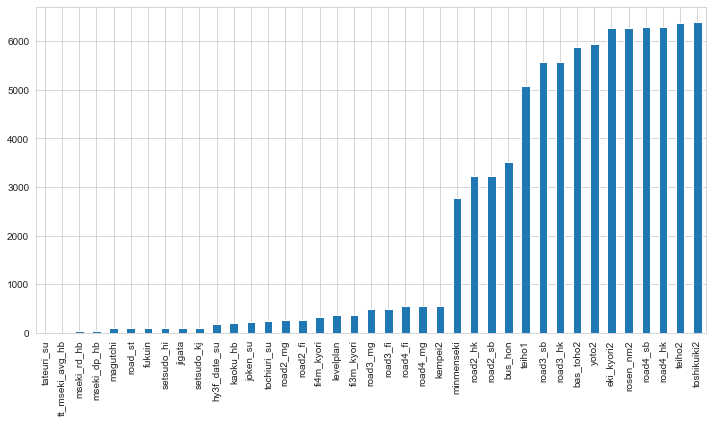

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig= plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

NAがある特徴が多い。

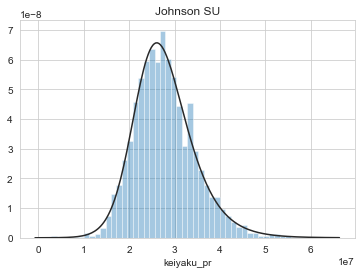

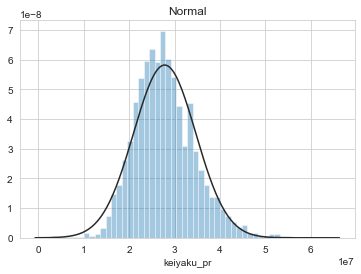

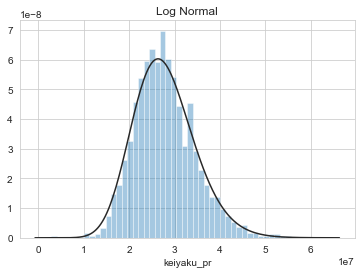

In [12]:
import scipy.stats as stats

plt.figure(1); plt.title('Johnson SU')
sns.distplot(y_train, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y_train, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y_train, kde=False, fit=stats.lognorm)

Normal Distributionからちょっと外れてるため、Johnson Distributionで修正。

In [13]:
import warnings
warnings.filterwarnings('ignore')

test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


In [14]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'keiyaku_pr']].groupby(feature).mean()['keiyaku_pr']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [15]:
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['yoto1_E', 'yoto2_E', 'josui_E', 'gesui_E', 'gas_E', 'usui_E', 'road1_hk_E', 'road1_sb_E', 'road2_hk_E', 'road2_sb_E', 'road3_hk_E', 'road3_sb_E', 'road4_hk_E', 'road4_sb_E', 'kaoku_um_E', 'yheki_umu_E', 'yheki_yohi_E', 'kborjs_E', 'hw_status_E', 'toshikuiki1_E', 'toshikuiki2_E', 'kodochiku_E', 'chikukeikaku_E', 'keikakuroad_E', 'kaihatsukyoka_E', 't53kyoka_E', 'hokakyoka_E', 'bokachiiki_E', 'kinshijiko_E', 'fi4m_yohi_E', 'fi3m_yohi_E', 'bus_yohi_E', 'rosen_nm1_E', 'bas_toho1_E', 'rosen_nm2_E', 'bas_toho2_E', 'levelplan_E', 'road_st_E', 'setsudo_hi_E', 'setsudo_kj_E', 'jigata_E', 'hiatari_E', '下水道法_E', '公拡法_E', '区画整理法_E', '国土法_E', '埋蔵文化財_E', '外壁後退_E', '文化財保護法_E', '文化財保護法（埋蔵文化財）_E', '景観地区_E', '景観法_E', '東日本震災復興特_E', '河川法_E', '自然公園法_E', '航空法_E', '農地法_E', '農地法届出要_E', '風致地区_E', 'ごみ置き場前_E', 'アパート南隣_E', 'エネファーム付_E', '三方路_E', '二方路_E', '交通量多い_E', '信号前_E', '信号近い_E', '前面道が坂途中_E', '地役権有_E', '嫌悪施設隣接_E', '宅内高低差あり_E', '床暖房付_E', '心理的瑕疵あり_E', '敷延2ｍ絞りあり_E', '横断歩道前_E', '眺望良_E', '行き止まり_E', '行き止まり途中_E', '

In [16]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['keiyaku_pr'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded

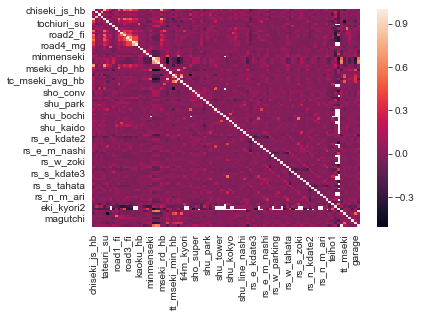

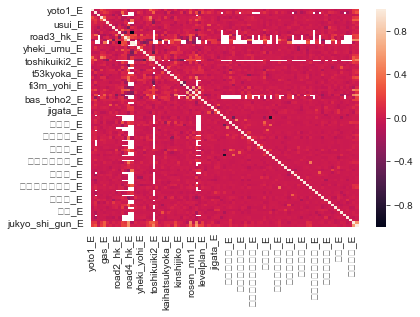

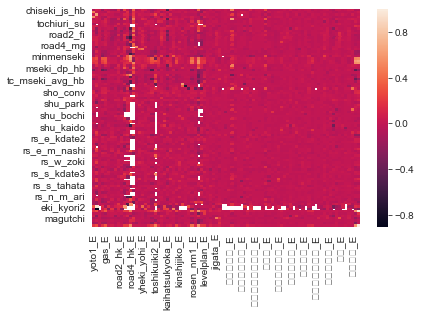

In [17]:
import numpy as np

plt.figure(1)
corr = train[quantitative+['keiyaku_pr']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['keiyaku_pr']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['keiyaku_pr'], columns=qual_encoded+['keiyaku_pr'])
for q1 in quantitative+['keiyaku_pr']:
    for q2 in qual_encoded+['keiyaku_pr']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

0.42198502724222886


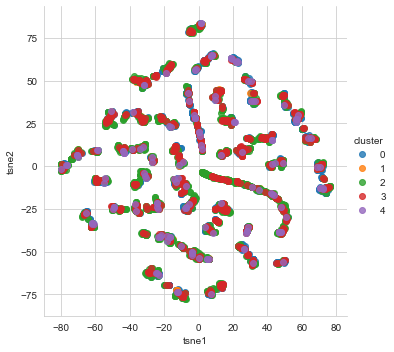

In [379]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

In [380]:
y = train['keiyaku_pr'].reset_index(drop=True)
train_features = train.drop(['keiyaku_pr'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [381]:
actually_categorical = ['garage','joken_su','kempei1','kempei2','tochiuri_su']
nan_None_columns = ['bas_toho2','eki_kyori2','kempei2','road2_hk','road2_sb','road3_hk','road3_sb','road4_hk','road4_sb', \
                    'road_st','tochiuri_su','toshikuiki2','yoto2','rosen_nm2']

for feat in actually_categorical:
    features[feat] = features[feat].apply(str)
features[nan_None_columns] = features[nan_None_columns].fillna('None')

In [382]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [383]:
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    try:
        features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
    except Exception:
        print('Not transforming feature {}'.format(features[i].name))

Not transforming feature tc_mseki_avg_hb


In [384]:
pd.options.display.max_columns = None
features.head()

,bas_toho1,bas_toho1_E,bas_toho2,bas_toho2_E,bokachiiki,bokachiiki_E,bus_hon,bus_yohi,bus_yohi_E,chikukeikaku,chikukeikaku_E,chiseki_js_hb,eki_kyori1,eki_kyori2,fi3m_kyori,fi3m_yohi,fi3m_yohi_E,fi4m_kyori,fi4m_yohi,fi4m_yohi_E,fukuin,garage,gas,gas_E,gesui,gesui_E,gk_chu_kyori,gk_sho_kyori,gk_yoc_tm,hiatari,hiatari_E,hokakyoka,hokakyoka_E,hw_status,hw_status_E,hy3f_date_su,jigata,jigata_E,joken_su,josui,josui_E,jukyo_shi_gun,jukyo_shi_gun_E,kaihatsukyoka,kaihatsukyoka_E,kaoku_hb,kaoku_um,kaoku_um_E,kborjs,kborjs_E,keikakuroad,keikakuroad_E,kempei1,kempei2,kijun_hb,kinshijiko,kinshijiko_E,kodochiku,kodochiku_E,koji_hb,levelplan,levelplan_E,magutchi,minmenseki,mseki_dp_hb,mseki_rd_hb,niwasaki,pj_no,road1_fi,road1_hk,road1_hk_E,road1_mg,road1_sb,road1_sb_E,road2_fi,road2_hk,road2_hk_E,road2_mg,road2_sb,road2_sb_E,road3_fi,road3_hk,road3_hk_E,road3_mg,road3_sb,road3_sb_E,road4_fi,road4_hk,road4_hk_E,road4_mg,road4_sb,road4_sb_E,road_st,road_st_E,rosen_nm1,rosen_nm1_E,rosen_nm2,rosen_nm2_E,rosenka_hb,rs_e_kdate2,rs_e_kdate3,rs_e_m_ari,rs_e_m_nashi,rs_e_parking,rs_e_tahata,rs_e_zoki,rs_n_kdate2,rs_n_kdate3,rs_n_m_ari,rs_n_m_nashi,rs_n_parking,rs_n_tahata,rs_n_zoki,rs_s_kdate2,rs_s_kdate3,rs_s_m_ari,rs_s_m_nashi,rs_s_parking,rs_s_tahata,rs_s_zoki,rs_w_kdate2,rs_w_kdate3,rs_w_m_ari,rs_w_m_nashi,rs_w_parking,rs_w_tahata,rs_w_zoki,setsudo_hi,setsudo_hi_E,setsudo_kj,setsudo_kj_E,sho_conv,sho_market,sho_shoten,sho_super,shu_bochi,shu_factory,shu_highway,shu_hvline,shu_jutaku,shu_kaido,shu_kokyo,shu_line_ari,shu_line_nashi,shu_park,shu_shop,shu_sogi,shu_soon,shu_tower,shu_zoki,t53kyoka,t53kyoka_E,tateuri_su,tc_mseki_avg_hb,tc_mseki_max_hb,tc_mseki_min_hb,teiho1,teiho2,tochiuri_su,toshikuiki1,toshikuiki1_E,toshikuiki2,toshikuiki2_E,tt_mseki,tt_mseki_avg_hb,tt_mseki_max_hb,tt_mseki_min_hb,usui,usui_E,yheki_kotei,yheki_umu,yheki_umu_E,yheki_yohi,yheki_yohi_E,yoseki1,yoto1,yoto1_E,yoto2,yoto2_E,ごみ置き場前,ごみ置き場前_E,アパート南隣,アパート南隣_E,エネファーム付,エネファーム付_E,三方路,三方路_E,下水道法,下水道法_E,二方路,二方路_E,交通量多い,交通量多い_E,信号前,信号前_E,信号近い,信号近い_E,公拡法,公拡法_E,前面道が坂途中,前面道が坂途中_E,区画整理法,区画整理法_E,国土法,国土法_E,地役権有,地役権有_E,埋蔵文化財,埋蔵文化財_E,外壁後退,外壁後退_E,嫌悪施設隣接,嫌悪施設隣接_E,宅内高低差あり,宅内高低差あり_E,床暖房付,床暖房付_E,心理的瑕疵あり,心理的瑕疵あり_E,敷延2ｍ絞りあり,敷延2ｍ絞りあり_E,文化財保護法,文化財保護法_E,文化財保護法（埋蔵文化財）,文化財保護法（埋蔵文化財）_E,景観地区,景観地区_E,景観法,景観法_E,東日本震災復興特,東日本震災復興特_E,横断歩道前,横断歩道前_E,河川法,河川法_E,眺望良,眺望良_E,自然公園法,自然公園法_E,航空法,航空法_E,行き止まり,行き止まり_E,行き止まり途中,行き止まり途中_E,街道沿い,街道沿い_E,裏道,裏道_E,角地,角地_E,計画道路,計画道路_E,踏切付近,踏切付近_E,車進入困難,車進入困難_E,農地法,農地法_E,農地法届出要,農地法届出要_E,風致地区,風致地区_E,高圧線下,高圧線下_E
0,徒歩,3.0,None,0.0,防火指定無,0.764372,0.000000,（不要）,2.0,（無）,1.0,4.003378,5.073176,None,0.0,（不要）,2.0,0.0,（不要）,1.0,2.168783,1,個別プロパン,1.0,公共下水,2.0,40.003768,31.733402,3.897662,普通,2.0,（不要）,1.0,更地,5.0,0.0,整形地,3.0,0.0,公営,2.0,朝霞,46.0,（不要）,2.0,0.000000,（無）,1.0,実測,2.0,（無）,1.0,60,0.0,5708.724201,（無）,1.0,第2種,2.373649,551.548256,2F/4LDK,7.154603,4.264023,0.0,0.000000,0.0,1.722454,0,1.004971,北,5.0,2.023898,私道,3.0,2.194487,東,2.101446,4.475541,私道,1.422908,0.0,None,0.0,0.0,None,0.0,0.0,None,0.0,0.0,None,0.0,問題なし,3.0,東武東上線,18.0,None,0.0,135000,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0,3.713254,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.000000,0.0,0.0,東,31.0,良い,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,（不要）,1.0,0.634025,109.26,4.427290,5.204038,0.0,0.0,0.0,市街化区域,3.0,None,0.0,104.43,121.290081,104.43,104.43,宅内処理,0.874562,0.332317,（無）,1.0,（不要）,1.0,200,工業地域,2.985756,None,0.0,無,2.0,無,1.0,無,1.0,無,1.0,無,1.0,無,1.0,無,2.0,無,1.0,無,1.0,無,2.0,無,2.0,無,1.0,無,1.0,無,1.0,無,1.0,無,1.0,無,2.0,無,2.0,有,2.0,無,2.0,無,2.0,無,2.0,無,2.0,無,1.0,無,2.0,無,2.0,無,1.0,無,2.0,無,2.0,無,2.0,無,2.0,無,2.0,無,1.0,無,2.0,無,2.0,無,1.0,無,1.0,無,2.0,無,2.0,無,1.0,無,2.0,無,1.0,無,1.0
1,徒歩,3.0,None,0.0,22条区域,1.284676,0.000000,（不要）,2.0,（無）,1.0,4.158888,4.395669,None,0.0,（不要）,2.0,0.0,（不要）,1.0,2.238591,1,個別プロパン,1.0,公共下水,2.0,52.212244,43.127528,3.534729,普通,2.0,（不要）,1.0,更地,5.0,0.0,不整形地,4.0,0.0,公営,2.0,川越,29.0,（不要）,2.0,0.000000,（無）,1.0,実測,2.0,（無）,1.0,60,0.0,2210.488804,（無）,1.0,指定無,1.671301,383.367205,2F/4LDK,7.154603,4.10180

In [385]:
features['avgPrice'] = (features['koji_hb']+features['kijun_hb']+features['rosenka_hb'])/3 
features.shape

(10734, 266)

In [386]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(10734, 683)

In [387]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((6461, 683), (6461,), (4273, 683))

In [388]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)
X.shape, y.shape, X_sub.shape

((6461, 587), (6461,), (4273, 587))

# Try LightGBM

In [389]:
import lightgbm as lgb 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold

# 3分割交差検証を指定し、インスタンス化 
kf = KFold(n_splits=5) 

# スコアとモデルを格納するリスト 
score_list = [] 
models = [] 

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

for fold_, (train_index, valid_index) in enumerate(kf.split(X, y)):
    train_x = X.iloc[train_index]
    valid_x = X.iloc[valid_index]
    train_y = y[train_index]
    valid_y = y[valid_index]
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_eval = lgb.Dataset(valid_x, valid_y, reference=lgb_train)
    print(f'fold{fold_ + 1} start')
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5000,
                valid_sets=lgb_eval,
                early_stopping_rounds=20,
                verbose_eval=0)
    y_pred = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
    score_list.append(mean_absolute_percentage_error(valid_y, y_pred))
    models.append(gbm)  # 学習が終わったモデルをリストに入れておく
    print(f'fold{fold_ + 1} end\nAccuracy = {mean_absolute_percentage_error(valid_y, y_pred)}')
print(score_list, '平均score', np.mean(score_list))

fold1 start
fold1 end
Accuracy = 9.294010346898181
fold2 start
fold2 end
Accuracy = 9.683258716617658
fold3 start
fold3 end
Accuracy = 8.824143594024111
fold4 start
fold4 end
Accuracy = 11.254251608500892
fold5 start
fold5 end
Accuracy = 10.090714025685172
[9.294010346898181, 9.683258716617658, 8.824143594024111, 11.254251608500892, 10.090714025685172] 平均score 9.829275658345203


In [390]:
test_pred = np.zeros((len(test), 5)) 
for fold_, gbm in enumerate(models):
    pred_ = gbm.predict(X_sub, num_iteration=gbm.best_iteration)# testを予測
    test_pred[:, fold_] = pred_ 
pred = np.mean(test_pred, axis=1)
first_submission['price'] = pred
first_submission.to_csv('lightgbm.tsv', sep='\t', index=False, header=False)

In [391]:
first_submission

,id,price
0,test_0000,1.744752e+07
1,test_0001,2.117258e+07
2,test_0002,2.104592e+07
3,test_0003,2.156574e+07
4,test_0004,2.160877e+07
5,test_0005,2.127768e+07
6,test_0006,2.164722e+07
7,test_0007,2.146246e+07
8,test_0008,2.114867e+07
9,test_0009,2.238806e+07
